# **Comparison Analysis**

## **Installing the modules**

In [1]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Loading the modules**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
np.random.seed(5)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
import random

## **Data**

Kaggle Data Source Link - [Kaggle | Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv)

The Pima Indian Diabetes dataset is used to predict whether or not the diagnosed patient has diabetes, which is also a Binary Classification problem, based on the various diagnostic feature values provided. The dataset used for this analysis is obtained from Kaggle. Although the dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The patient dynamics provided in this dataset is that of female patients who are at least 21 years old and of Pima Indian heritage.  The datasets used might be derived and transformed datasets from original datasets. The sources of the original datasets will be mentioned and I would strongly recommend to look at the original data for more details on the data description and for a more detailed analysis.

Kaggle Data Source Link - [Kaggle | Daily Female Births Dataset](https://www.kaggle.com/dougcresswell/daily-total-female-births-in-california-1959)

This is a time series dataset used for building predictive models. The data is about total number of female births recorded in California, USA on 1959. It consists of the time index and the count of female birth and consist around 365 records.

## **Loading the data**

In [3]:
data  = pd.read_csv('Datasets/diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.shape

(768, 9)

## **Data Preprocessing**

Perform some preliminary pre-processing and very basic exploration as our main focus is on the comparison analysis. And since some of these methods are already covered in sufficient details in other notebook tutorials provided, try to jump to the important steps for the comparison analysis.

In [5]:
data[(data['BMI'] == 0) & (data['Glucose'] == 0) & (data['BloodPressure'] == 0)]
data[(data['Glucose'] == 0)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


From the above observation, it looks like the data does have a lot of noise, as there are multiple cases where some of the key features are 0. But, following human intuition, since blood glucose level is one of the key features to observe diabetes, I would consider dropping all records where Glucose value is 0.

In [6]:
cleaned_data = data[(data['Glucose'] != 0)]
cleaned_data.shape

(763, 9)

In [7]:
feature_engg_data = cleaned_data.copy()
outlier_data = cleaned_data.copy()
factor = 3
# Include this only for columns with suspected outliers
# Using a factor of 3, following Nelson's rule 1 to remove outliers - https://en.wikipedia.org/wiki/Nelson_rules
# Only for non-categorical fields
columns_to_include = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']
for column in columns_to_include:
    upper_lim = feature_engg_data[column].mean () + feature_engg_data[column].std () * factor
    lower_lim = feature_engg_data[column].mean () - feature_engg_data[column].std () * factor
    feature_engg_data = feature_engg_data[(feature_engg_data[column] < upper_lim) & (feature_engg_data[column] > lower_lim)]
    
outlier_data = pd.concat([outlier_data, feature_engg_data]).drop_duplicates(keep=False)

print(feature_engg_data.shape)
print(outlier_data.shape)

(688, 9)
(75, 9)


In the following section in-order to build the model, we will need to normalize the data and split the data into train, validation and test dataset. The outlier data that we have, we will keep it separate, just in case to see how does our model performs on the outlier dataset.

In [8]:
def normalize_data(df):
    val = df.values 
    min_max_normalizer = preprocessing.MinMaxScaler()
    norm_val = min_max_normalizer.fit_transform(val)
    df2 = pd.DataFrame(norm_val, columns=df.columns)
    
    return df2

norm_feature_engg_data = normalize_data(feature_engg_data)
norm_outlier_data = normalize_data(outlier_data)

In the previous steps we have done some fundamental steps to understand and prepare the data so that it can be used for further modeling. Let's split the data and then we will try to apply the comparison analysis for result visualization based explainability.

## **Splitting the data**

In [9]:
input_data = norm_feature_engg_data.drop(['Outcome'],axis='columns')
targets =norm_feature_engg_data.filter(['Outcome'],axis='columns')

x, x_test, y, y_test = train_test_split(input_data,targets,test_size=0.1,train_size=0.9, random_state=5)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.22,train_size =0.78, random_state=5)

## **t-SNE based visualization**

Now, to compare the classes and the formation of the clusters, we will perform t-SNE based visualization and observe the goodness of the clusters. If the clusters are not compact and well separated, it is highly possible that any classification algorithm will not work effectively because of the data formation.t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction method, which is often used with clustering. To find out more on this method, please refer this link: https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1.

In [10]:
def visualize_clusters(x, labels, hue = "hls"):
    '''
    Visualization of clusters using t-SNE plots
    '''
    tsne_transformed = TSNE(n_components=2, random_state = 0).fit_transform(x)

    df_tsne_subset = pd.DataFrame()
    df_tsne_subset['tsne-one'] = tsne_transformed[:,0]
    df_tsne_subset['tsne-two'] = tsne_transformed[:,1]
    df_tsne_subset['y'] = labels

    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x="tsne-one", y="tsne-two",
        hue="y",
        palette=sns.color_palette(hue,df_tsne_subset['y'].nunique()),
        data=df_tsne_subset,
        legend="full",
        alpha=1.0
    )
    plt.show()

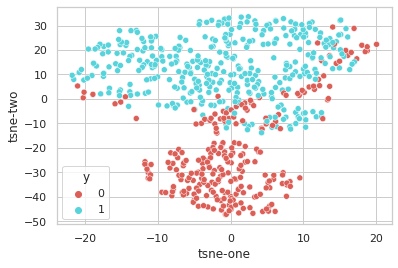

In [11]:
# K-means
model = KMeans(n_clusters=2, init='k-means++', random_state=0)
model.fit(x)
km_labels = model.predict(x)
visualize_clusters(x, km_labels)

As we can see that overall, the clusters does have a compact shape and can be separated. If the clusters were not properly formed and if the t_SNE transfored data points we sparse and spread out, we could have hypothesized that any classification algorithm might also fail. But in this, apart from few data points, most of the points are part pf th two distinguishable clusters which are formed. More detailed comparison analysis can be done to identify key information about those points which are not part of the correct clusters. But we will not cover those in this notebook to keep things simple!

## **Comparison Analysis for time series data**

In [12]:
plt.rcParams["figure.figsize"] = (15,5)
series = pd.read_csv('Datasets/daily-total-female-births.csv', header=0, index_col=0)
series.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


<AxesSubplot:xlabel='Date'>

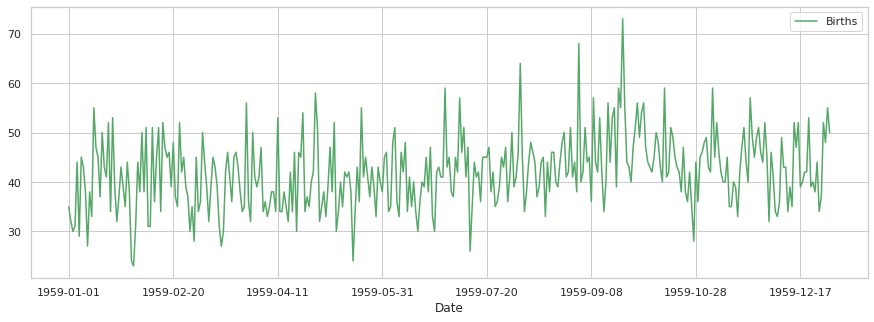

In [13]:
series.plot(color = 'g')

In [14]:
X = series.values
X = X.astype('float32')
size = len(X) - 1
train, test = X[0:size], X[size:]
# fit an ARIMA model
model = ARIMA(train, order=(2,1,1)) # Simple ARIMA time series forecast model
model_fit = model.fit()
# forecast
forecast = model_fit.predict(start=366, end=466)
for i in range(len(forecast)):
    forecast[i] = random.random() * 10 + forecast[i]
result = model_fit.get_forecast()
con_interval = result.conf_int(0.05)

In [15]:
forecast_ub = forecast + 0.5 * con_interval[0][1] # Upper bound and lower bound of confidence interval
forecast_lb = forecast - 0.5 * con_interval[0][0]

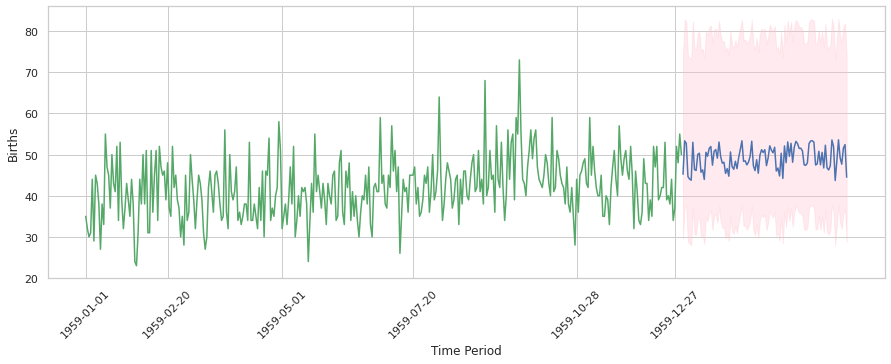

In [16]:
plt.plot(series.index, series['Births'], color = 'g')
plt.plot(list(range(len(series.index), len(series.index)+101)),forecast, color = 'b')
plt.fill_between(list(range(len(series.index), len(series.index)+101)), forecast_lb, forecast_ub, alpha = 0.3, color = 'pink')
plt.xlabel('Time Period')
plt.xticks([0, 50, 120, 200, 300, 360],[series.index[0],series.index[50], series.index[120], series.index[200], series.index[300], series.index[360]] ,rotation=45)
plt.ylabel('Births')
plt.show()

From the above plot, we can see the confidence band around the predicted values. Although, our model isn't very accurate, but our focus is on understanding the importance of the comparison analysis. The confidence band gives us a clear indication the range of values that the forecast can take. So, it helps in setting up the right expectation of the best case and worst case scenario and is quite effective rather than just a single point estimation. Even if the actual model prediction is incorrect, the confidence interval showing the possible range of values can prevent any shock for end stakeholders and can eventually make the model more trustworthy.

## **Final Thoughts**

The methods explored in this notebook, are quite simple and helpful for complete black-box models. I strongly recommend to try out more examples and more problems to understand these approaches much better.

## **References**

1. [Kaggle | Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv)
2. [Kaggle | Daily Female Births Dataset](https://www.kaggle.com/dougcresswell/daily-total-female-births-in-california-1959)
3. An Introduction to t-SNE with Python Example, by Andre Violante - https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1
4. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073